This notebook calculates all of the SNeCO CDFs, 
some stats about the fraction of CO emission at 150 pc and 
writes the SNeCDFs to a fits file and writes 6 versions of the allPixel CDFs to a fits file. 

'../Data/3.2a.SNeCDFs.fits'

SNeCDFs = {'Detections','NonDetections','DetectionsII','NonDetectionsII','DetectionsIa','NonDetectionsIa'  : 'DetectionsIbc','NonDetectionsIbc','DetectionsUnC','NonDetectionsUnC'}

each of these rows holds CDFdetection,ydetection,CDFdetection_mgsd_ca,ydetection_mgsd_ca,CDFdetection_mgsd_mda,ydetection_mgsd_mda

'../Data/3.2a_CDFAllPixelsInts.fits'           :   CDFAllPixelsInts, yAllPixelsInts
'../Data/3.2a_CDFAllPixelsLims.fits'           :   CDFAllPixelsLims, yAllPixelsLims
'../Data/3.2a_CDFAllPixelsInts_ca.fits'        :   CDFAllPixelsInts_ca, yAllPixelsInts_ca
'../Data/3.2a_CDFAllPixelsLims_ca.fits'        :   CDFAllPixelsLims_ca, yAllPixelsLims_ca
'../Data/3.2a_CDFAllPixelsInts_mgsd_mda.fits'  :   CDFAllPixelsInts_mgsd_mda, yAllPixelsInts_mgsd_mda
'../Data/3.2a_CDFAllPixelsLims_mgsd_mda.fits'  :   CDFAllPixelsLims_mgsd_mda, yAllPixelsLims_mgsd_mda


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from astropy import table
from astropy.table import Table, join
from astropy.io import ascii
import astropy.io.fits as pyfits

import os

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
#sys.path.append('/Users/nessmayker/Desktop/NessPythonFunctions')
from detectionFraction import detecFrac
from cumulativeDistFunc import makeCDF
from findPercentiles import findStats
from flattenList import flatten
from nonZeroError import findErrVals
from findAtIndex import findClosest

#import SNe data 

SNe_Gal_File = '../Data/3.SNe+GalData.csv'
SNe_Gal_Data = Table.read(SNe_Gal_File, format='csv') 

intenFile = '../Data/3.IntenData.csv'
intenData = Table.read(intenFile, format='csv')

database  = join(SNe_Gal_Data, intenData, keys=('SN_name', 'galaxy'))


In [2]:
database[0:1]

# for i in range(len(database)):
#     print(database["SN_type"][i])

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,NatRes,NatInt,pc60Int,pc90Int,pc120Int,pc150Int,pc500Int,pc750Int,pc1000Int,NatErr,pc60Err,pc90Err,pc120Err,pc150Err,pc500Err,pc750Err,pc1000Err,NatEW,pc60EW,pc90EW,pc120EW,pc150EW,pc500EW,pc750EW,pc1000EW,NatSNR,pc60SNR,pc90SNR,pc120SNR,pc150SNR,pc500SNR,pc750SNR,pc1000SNR,alphaCO,pc60mgsd,pc90mgsd,pc120mgsd,pc150mgsd,pc500mgsd,pc750mgsd,pc1000mgsd,pc60mgsdErr,pc90mgsdErr,pc120mgsdErr,pc150mgsdErr,pc500mgsdErr,pc750mgsdErr,pc1000mgsdErr
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str74,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ngc1566,ASASSN-14ha,II,65.0059,-54.9381,258.9038295074317,423.1062029210927,68.05383,1.8849889,12.188041,0.0003484111476313,65.00159,-54.93801,17.69,214.7,29.5,216.83093,12m+7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1566/ngc1566_12m+7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1566/ngc1566_12m+7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/NGC1566_alphaCO21_Sun+20.fits,107.5715044627487,68.0538330078125,nan,nan,65.95396423339844,61.926334381103516,27.371265411376953,26.06928253173828,27.377416610717773,1.8849889039993286,nan,nan,1.6742128133773804,1.3591481447219849,0.5764862298965454,0.3906446397304535,0.27018043398857117,12.188040733337402,nan,nan,12.932862281799316,13.762829780578613,19.730430603027344,29.85703468322754,43.81895446777344,36.10304170142571,nan,nan,39.39401473122755,45.56260818335635,47.47947824580116,66.73400804814882,101.33012300911419,4.304510126195559,nan,nan,283.8995069054033,266.5625334216323,117.81988913005836,112.21549064052044,117.84636702990916,nan,nan,7.20666600858929,5.850466951955691,2.481490814201981,1.6815338074637531,1.1629944140037154


In [3]:
# Find which SNe have nan values and which have finite
nans   = np.argwhere(np.isnan(database["pc150Int"]))
finite = np.argwhere(np.isfinite(database["pc150Int"]))

numSNe    = len(database["pc150Int"])
numFinite = len(finite)
numNans   = len(nans)

# Create array of intensity, errpr, & SNR values where measurements are finite
SNRvalues    = database["pc150SNR"][finite]
values       = database["pc150Int"][finite]
errors       = database["pc150Err"][finite]
alphaCO_Sun  = database["alphaCO"][finite]

# Find which are considered non-detections and which are detections
detections_idx, um    = np.where(SNRvalues >= 3.0)
nondetections_idx, um = np.where(SNRvalues < 3.0)

detections_int    = flatten(values[detections_idx])

nondetections_int = flatten(values[nondetections_idx])

numDetect    = len(detections_int)
numNonDetect = len(nondetections_int)

# assign nondetections upper limits as a value of 3x the noise.
nondetections_ul = flatten(3 * errors[nondetections_idx])

print("Out of", numSNe, "supernovae,", numFinite, "or", round(numFinite/numSNe*100, 0), "percent of the sample are within the PHANGS-ALMA footprint at 150pc resolution.")
print("Out of these,", numDetect, "or", round(numDetect/numFinite*100, 0), "percent of the sample have a SNR of 3.0 or greater and are classified as coinciding in areas with detectable CO2-1 emission.")
print("The remaining", numNonDetect, "are assigned an upper limit CO2-1 intensity measurement of 3 times the noise value at their location.")


Out of 63 supernovae, 59 or 94.0 percent of the sample are within the PHANGS-ALMA footprint at 150pc resolution.
Out of these, 36 or 61.0 percent of the sample have a SNR of 3.0 or greater and are classified as coinciding in areas with detectable CO2-1 emission.
The remaining 23 are assigned an upper limit CO2-1 intensity measurement of 3 times the noise value at their location.


In [4]:
# for i in range(len(database["SN_type"][finite])):
#     print(database["SN_type"][finite][i])
# print(i)

In [5]:
# Sort measurements by SN Type and separate detections from nondetections.

SNtypes = database["SN_type"][finite]

typeII_idx, um    = np.where(SNtypes=="II")
typeIa_idx, um    = np.where(SNtypes=="Ia")
typeIb_idx, um    = np.where(SNtypes=="Ib")
typeIc_idx, um    = np.where(SNtypes=="Ic")
typeIIb_idx, um   = np.where(SNtypes=="IIb")
typeIIn_idx, um   = np.where(SNtypes=="IIn")
typeIInLBV_idx, um = np.where(SNtypes=="IIn/LBV")

typeIInAll_idx = np.concatenate((typeIIn_idx, typeIInLBV_idx), axis = 0)
typeIInAll_idx.sort() 

typeSESN_idx = np.concatenate((typeIb_idx, typeIc_idx, typeIIb_idx), axis = 0)
typeSESN_idx.sort()  

typeI_idx, um = np.where(SNtypes=="I")
typeUnk_idx, um = np.where(SNtypes=="unclassified")
typeUnC_idx = np.concatenate((typeI_idx, typeUnk_idx), axis = 0)
typeUnC_idx.sort()

numTypeII  = len(typeII_idx)
numTypeIa  = len(typeIa_idx)
numTypeSESN = len(typeSESN_idx)
numTypeUnC = len(typeUnC_idx)
numTypeIIn = len(typeIInAll_idx)
numTypeIIb = len(typeIIb_idx)
numTypeIb = len(typeIb_idx)
numTypeIc = len(typeIc_idx)


print("Type II: ",numTypeII)
print("Type Ia: ",numTypeIa)
print("SESNe: ",numTypeSESN)
print("Unclassified: ",numTypeUnC)
print("Type IIn: ",numTypeIIn)
print("Type IIb: ",numTypeIIb)
print("Type Ib: ",numTypeIb)
print("Type Ic: ",numTypeIc)


Type II:  32
Type Ia:  12
SESNe:  8
Unclassified:  7
Type IIn:  0
Type IIb:  1
Type Ib:  2
Type Ic:  5


In [6]:
def findSignal(typeIdx, values=values, errors=errors, detectionIdx = detections_idx, nondetectionIdx = nondetections_idx):
    typeDetectIdx    = np.intersect1d(typeIdx, detectionIdx)
    typeNonDetectIdx = np.intersect1d(typeIdx, nondetectionIdx)
    numDetect    = len(typeDetectIdx)
    numNonDetect = len(typeNonDetectIdx)
    detectionsInt   = flatten(values[typeDetectIdx])
    nondetectionsUL = flatten(3 * errors[typeNonDetectIdx])
    return(typeDetectIdx, typeNonDetectIdx, numDetect, numNonDetect, detectionsInt, nondetectionsUL)

# find indicies of each SN type where there is both a detection and nondetection
typeII_d_Idx, typeII_nd_Idx, numtypeII_d, numtypeII_nd, detectionsII_int, nondetectionsII_ul = findSignal(typeII_idx)
typeIa_d_Idx, typeIa_nd_Idx, numtypeIa_d, numtypeIa_nd, detectionsIa_int, nondetectionsIa_ul = findSignal(typeIa_idx)
typeSESN_d_Idx, typeSESN_nd_Idx, numtypeSESN_d, numtypeSESN_nd, detectionsSESN_int, nondetectionsSESN_ul = findSignal(typeSESN_idx)
typeUnC_d_Idx, typeUnC_nd_Idx, numtypeUnC_d, numtypeUnC_nd, detectionsUnC_int, nondetectionsUnC_ul = findSignal(typeUnC_idx)
typeIIn_d_Idx, typeIIn_nd_Idx, numtypeIIn_d, numtypeIIn_nd, detectionsIIn_int, nondetectionsIIn_ul = findSignal(typeIInAll_idx)
typeIIb_d_Idx, typeIIb_nd_Idx, numtypeIIb_d, numtypeIIb_nd, detectionsIIb_int, nondetectionsIIb_ul = findSignal(typeIIb_idx)
typeIb_d_Idx, typeIb_nd_Idx, numtypeIb_d, numtypeIb_nd, detectionsIb_int, nondetectionsIb_ul = findSignal(typeIb_idx)
typeIc_d_Idx, typeIc_nd_Idx, numtypeIc_d, numtypeIc_nd, detectionsIc_int, nondetectionsIc_ul = findSignal(typeIc_idx)

# This is how to access these indexed lists
# print(database["SN_type"][finite][typeIIdetections_idx])

print("We have ", round(numtypeII_d/numTypeII * 100,0), "percent CO 2-1 detections at the location of our",  numTypeII, "typeII SNe.")
print("We have ", round(numtypeIa_d/numTypeIa * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIa, "typeIa SNe.")
print("We have ", round(numtypeSESN_d/numTypeSESN * 100,0), "percent CO 2-1 detections at the location of our",  numTypeSESN, "SESNe.")
print("We have ", round(numtypeUnC_d/numTypeUnC * 100,0), "percent CO 2-1 detections at the location of our",  numTypeUnC, "untyped SNe.")
# print("We have ", round(numtypeIIn_d/numTypeIIn * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIIn, "Type IIn SNe.")
print("We have ", round(numtypeIIb_d/numTypeIIb * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIIb, "Type IIb SNe.")
print("We have ", round(numtypeIb_d/numTypeIb * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIb, "Type Ib SNe.")
print("We have ", round(numtypeIc_d/numTypeIc * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIc, "Type Ic SNe.")



We have  56.0 percent CO 2-1 detections at the location of our 32 typeII SNe.
We have  33.0 percent CO 2-1 detections at the location of our 12 typeIa SNe.
We have  88.0 percent CO 2-1 detections at the location of our 8 SESNe.
We have  100.0 percent CO 2-1 detections at the location of our 7 untyped SNe.
We have  100.0 percent CO 2-1 detections at the location of our 1 Type IIb SNe.
We have  50.0 percent CO 2-1 detections at the location of our 2 Type Ib SNe.
We have  100.0 percent CO 2-1 detections at the location of our 5 Type Ic SNe.


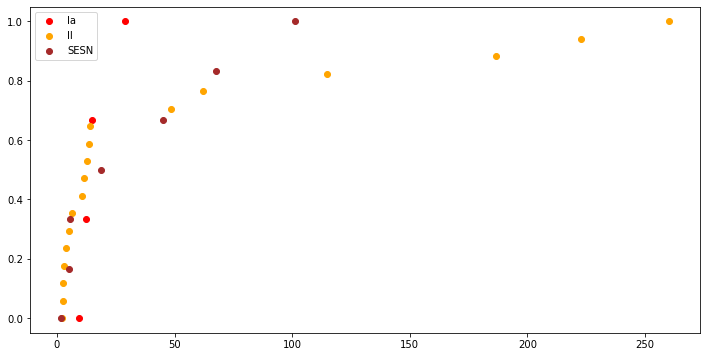

In [7]:
#numtypeII_d, numtypeII_nd, detectionsII_int, nondetectionsII_ul

def makeYs(numD, numND):
    yD  = np.linspace(0.0,1.0, numD)
    yND = np.linspace(0.0,1.0, numND)
    return(yD, yND)


yIa_d, yIa_nd = makeYs(numtypeIa_d, numtypeIa_nd)
yII_d, yII_nd = makeYs(numtypeII_d, numtypeII_nd)
yIb_d, yIb_nd = makeYs(numtypeIb_d, numtypeIb_nd)
yIc_d, yIc_nd = makeYs(numtypeIc_d, numtypeIc_nd)
yIIb_d, yIIb_nd = makeYs(numtypeIIb_d, numtypeIIb_nd)
yIIn_d, yIIn_nd = makeYs(numtypeIIn_d, numtypeIIn_nd)
ySESN_d, ySESN_nd = makeYs(numtypeSESN_d, numtypeSESN_nd)
yUnC_d, yUnC_nd = makeYs(numtypeUnC_d, numtypeUnC_nd)


plt.figure(figsize = (12,6))
plt.scatter(np.sort(detectionsIa_int), yIa_d, label = "Ia", color = "red")
#plt.scatter(np.sort(nondetectionsIa_ul), yIa_nd, color = "red", marker = "<")
plt.scatter(np.sort(detectionsII_int), yII_d, label = "II", color = "orange")
#plt.scatter(np.sort(nondetectionsII_ul), yII_nd, color = "orange", marker = "<")
# plt.scatter(np.sort(detectionsIb_int), yIb_d, label = "Ib", color = "gold")
# plt.scatter(np.sort(nondetectionsIb_ul), yIb_nd, color = "gold", marker = "<")
# plt.scatter(np.sort(detectionsIc_int), yIc_d, label = "Ic", color = "green")
# plt.scatter(np.sort(nondetectionsIc_ul), yIc_nd, color = "green", marker = "<")
# plt.scatter(np.sort(detectionsIIb_int), yIIb_d, label = "IIb", color = "blue")
# plt.scatter(np.sort(nondetectionsIIb_ul), yIIb_nd, color = "blue", marker = "<")
# plt.scatter(np.sort(detectionsIIn_int), yIIn_d, label = "IIn", color = "purple")
# plt.scatter(np.sort(nondetectionsIIn_ul), yIIn_nd, color = "purple", marker = "<")
plt.scatter(np.sort(detectionsSESN_int), ySESN_d, label = "SESN", color = "brown")
#plt.scatter(np.sort(nondetectionsSESN_ul), ySESN_nd, color = "brown", marker = "<")
#plt.scatter(np.sort(detectionsUnC_int), yUnC_d, label = "UnC", color = "black")
# plt.scatter(np.sort(nondetectionsUnC_ul), yUnC_nd, color = "black", marker = "<")

plt.legend(loc='best')

In [8]:
# # Make CDFs of detections and by each type.

frac = numNonDetect/numFinite
fracII = numtypeII_nd/numTypeII
fracIa = numtypeIa_nd/numTypeIa
fracSESN = numtypeSESN_nd/numTypeSESN
fracUnC = numtypeUnC_nd/numTypeUnC

def yStart(numSample):
    start = 1.0/numSample
    return(start)

startAll = yStart(numFinite)       
CDFdetection, ydetection       = makeCDF(detections_int, min=frac+startAll)
CDFnondetection, ynondetection = makeCDF(nondetections_ul, min = startAll, max=frac)

startII = yStart(numTypeII)      
CDFdetectionII, ydetectionII      = makeCDF(detectionsII_int, min=fracII+startII)
CDFnondetectionII, ynondetectionII = makeCDF(nondetectionsII_ul, min = startII, max=fracII)

startIa = yStart(numTypeIa)       
CDFdetectionIa, ydetectionIa      = makeCDF(detectionsIa_int, min=fracIa+startIa)
CDFnondetectionIa, ynondetectionIa = makeCDF(nondetectionsIa_ul, min = startIa, max=fracIa)

startSESN = yStart(numTypeSESN)       
CDFdetectionSESN, ydetectionSESN      = makeCDF(detectionsSESN_int, min=fracSESN+startSESN)
CDFnondetectionSESN, ynondetectionSESN = makeCDF(nondetectionsSESN_ul, min = startSESN, max=fracSESN)

startUnC = yStart(numTypeUnC)       
CDFdetectionUnC, ydetectionUnC      = makeCDF(detectionsUnC_int, min=fracUnC+startUnC)
CDFnondetectionUnC, ynondetectionUnC = makeCDF(nondetectionsUnC_ul, min = startUnC, max=fracUnC)


In [9]:
# Convert to molecular gas surface density using constant alphaCO

# alphaCO = 4.35/0.65

# detections_mgsd_ca       = [x * alphaCO for x in detections_int]
# nondetections_mgsd_ca    = [x * alphaCO for x in nondetections_ul]

# detectionsII_mgsd_ca     = [x * alphaCO for x in detectionsII_int]
# nondetectionsII_mgsd_ca  = [x * alphaCO for x in nondetectionsII_ul]

# detectionsIa_mgsd_ca     = [x * alphaCO for x in detectionsIa_int]
# nondetectionsIa_mgsd_ca  = [x * alphaCO for x in nondetectionsIa_ul]

# detectionsIbc_mgsd_ca    = [x * alphaCO for x in detectionsIbc_int]
# nondetectionsIbc_mgsd_ca = [x * alphaCO for x in nondetectionsIbc_ul]

# detectionsUnC_mgsd_ca    = [x * alphaCO for x in detectionsUnC_int]
# nondetectionsUnC_mgsd_ca = [x * alphaCO for x in nondetectionsUnC_ul]

# CDFdetection_mgsd_ca, ydetection_mgsd_ca            = makeCDF(detections_mgsd_ca, min=frac+startAll)
# CDFnondetection_mgsd_ca, ynondetection_mgsd_ca      = makeCDF(nondetections_mgsd_ca, min = startAll, max=frac)

# CDFdetectionII_mgsd_ca, ydetectionII_mgsd_ca        = makeCDF(detectionsII_mgsd_ca, min=fracII+startII)
# CDFnondetectionII_mgsd_ca, ynondetectionII_mgsd_ca   = makeCDF(nondetectionsII_mgsd_ca, min = startII, max=fracII)

# CDFdetectionIa_mgsd_ca, ydetectionIa_mgsd_ca        = makeCDF(detectionsIa_mgsd_ca, min=fracIa+startIa)
# CDFnondetectionIa_mgsd_ca, ynondetectionIa_mgsd_ca   = makeCDF(nondetectionsIa_mgsd_ca, min = startIa, max=fracIa)

# CDFdetectionIbc_mgsd_ca, ydetectionIbc_mgsd_ca      = makeCDF(detectionsIbc_mgsd_ca, min=fracIbc+startIbc)
# CDFnondetectionIbc_mgsd_ca, ynondetectionIbc_mgsd_ca = makeCDF(nondetectionsIbc_mgsd_ca, min = startIbc, max=fracIbc)

# CDFdetectionUnC_mgsd_ca, ydetectionUnC_mgsd_ca      = makeCDF(detectionsUnC_mgsd_ca, min=fracUnC+startUnC)
# CDFnondetectionUnC_mgsd_ca, ynondetectionUnC_mgsd_ca = makeCDF(nondetectionsUnC_mgsd_ca, min = startUnC, max=fracUnC)



In [10]:
# Convert to molecular gas surface density using Sun+20 alphaCO


detections_mgsd_mda       = [a*b for a,b in zip(detections_int, flatten(alphaCO_Sun[detections_idx]))]
nondetections_mgsd_mda    = [a*b for a,b in zip(nondetections_ul, flatten(alphaCO_Sun[nondetections_idx]))]

detectionsII_mgsd_mda     = [a*b for a,b in zip(detectionsII_int, flatten(alphaCO_Sun[typeII_d_Idx]))]
nondetectionsII_mgsd_mda  = [a*b for a,b in zip(nondetectionsII_ul, flatten(alphaCO_Sun[typeII_nd_Idx]))]

detectionsIa_mgsd_mda     = [a*b for a,b in zip(detectionsIa_int, flatten(alphaCO_Sun[typeIa_d_Idx]))]
nondetectionsIa_mgsd_mda  = [a*b for a,b in zip(nondetectionsIa_ul, flatten(alphaCO_Sun[typeIa_nd_Idx]))]

detectionsSESN_mgsd_mda    = [a*b for a,b in zip(detectionsSESN_int, flatten(alphaCO_Sun[typeSESN_d_Idx]))]
nondetectionsSESN_mgsd_mda = [a*b for a,b in zip(nondetectionsSESN_ul, flatten(alphaCO_Sun[typeSESN_nd_Idx]))]

detectionsUnC_mgsd_mda    = [a*b for a,b in zip(detectionsUnC_int, flatten(alphaCO_Sun[typeUnC_d_Idx]))]
nondetectionsUnC_mgsd_mda = [a*b for a,b in zip(nondetectionsUnC_ul, flatten(alphaCO_Sun[typeUnC_nd_Idx]))]

CDFdetection_mgsd_mda, ydetection_mgsd_mda       = makeCDF(detections_mgsd_mda, min=frac+startAll)
CDFnondetection_mgsd_mda, ynondetection_mgsd_mda = makeCDF(nondetections_mgsd_mda, min = startAll, max=frac)

CDFdetectionII_mgsd_mda, ydetectionII_mgsd_mda      = makeCDF(detectionsII_mgsd_mda, min=fracII+startII)
CDFnondetectionII_mgsd_mda, ynondetectionII_mgsd_mda = makeCDF(nondetectionsII_mgsd_mda, min = startII, max=fracII)

CDFdetectionIa_mgsd_mda, ydetectionIa_mgsd_mda      = makeCDF(detectionsIa_mgsd_mda, min=fracIa+startIa)
CDFnondetectionIa_mgsd_mda, ynondetectionIa_mgsd_mda = makeCDF(nondetectionsIa_mgsd_mda, min = startIa, max=fracIa)

CDFdetectionSESN_mgsd_mda, ydetectionSESN_mgsd_mda      = makeCDF(detectionsSESN_mgsd_mda, min=fracSESN+startSESN)
CDFnondetectionSESN_mgsd_mda, ynondetectionSESN_mgsd_mda = makeCDF(nondetectionsSESN_mgsd_mda, min = startSESN, max=fracSESN)

CDFdetectionUnC_mgsd_mda, ydetectionUnC_mgsd_mda      = makeCDF(detectionsUnC_mgsd_mda, min=fracUnC+startUnC)
CDFnondetectionUnC_mgsd_mda, ynondetectionUnC_mgsd_mda = makeCDF(nondetectionsUnC_mgsd_mda, min = startUnC, max=fracUnC)



In [11]:

SNeCDFs = Table({'Detections'      : [CDFdetection,ydetection,CDFdetection_mgsd_mda,ydetection_mgsd_mda],
                'NonDetections'    : [CDFnondetection,ynondetection,CDFnondetection_mgsd_mda,ynondetection_mgsd_mda],
                'DetectionsII'     : [CDFdetectionII,ydetectionII,CDFdetectionII_mgsd_mda,ydetectionII_mgsd_mda],
                'NonDetectionsII'  : [CDFnondetectionII,ynondetectionII,CDFnondetectionII_mgsd_mda,ynondetectionII_mgsd_mda],
                'DetectionsIa'     : [CDFdetectionIa,ydetectionIa,CDFdetectionIa_mgsd_mda,ydetectionIa_mgsd_mda],
                'NonDetectionsIa'  : [CDFnondetectionIa,ynondetectionIa,CDFnondetectionIa_mgsd_mda,ynondetectionIa_mgsd_mda],
                'DetectionsSESN'    : [CDFdetectionSESN,ydetectionSESN,CDFdetectionSESN_mgsd_mda,ydetectionSESN_mgsd_mda],
                'NonDetectionsSESN' : [CDFnondetectionSESN,ynondetectionSESN,CDFnondetectionSESN_mgsd_mda,ynondetectionSESN_mgsd_mda] ,
                'DetectionsUnC'    : [CDFdetectionUnC,ydetectionUnC,CDFdetectionUnC_mgsd_mda,ydetectionUnC_mgsd_mda],
                'NonDetectionsUnC' : [CDFnondetectionUnC,ynondetectionUnC,CDFnondetectionUnC_mgsd_mda,ynondetectionUnC_mgsd_mda]})


SNeCDFs.write('../Data/3.2a.SNeCDFs.fits', overwrite=True)



In [12]:
#!pip install reproject
from reproject import reproject_interp
########### GETTING ALL PIXEL VALUES HERE #################

# filename: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc2997/ngc2997_12m+7m+tp_co21_150pc_broad_mom0.fits

# Isolate unique galaxy names
unique_by_name = table.unique(database, keys='galaxy')
galaxyName, intfile, errfile, acofile = [],[],[],[]

# Create list of Filenames
for i in range(len(unique_by_name)):
    prefix = "/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/"
    galaxy = unique_by_name['galaxy'][i]
    telOrient = unique_by_name['telOrient'][i]
    int_suffix = "_co21_150pc_broad_mom0.fits"
    err_suffix = "_co21_150pc_broad_emom0.fits"
    intname =  prefix + galaxy + "/" + galaxy + "_" + telOrient + int_suffix
    errname =  prefix + galaxy + "/" + galaxy + "_" + telOrient + err_suffix
    
    GalName = galaxy.strip().upper()
    
    if GalName == 'CIRCINUS':
        GalName = 'ESO097-013'
        
    aconame =  "/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/" + GalName + '_alphaCO21_Sun+20.fits'
    
    intfile.append(intname)
    errfile.append(errname)
    acofile.append(aconame) 
    galaxyName.append(galaxy)
    
# Pull intensity values out of galaxy maps for CDF and assign them as three sigma measurements or below

threeSigmaInts, nonThreeSigmaInts, threeSigma_mgsd_mda, nonThreeSigma_mgsd_mda = [],[],[],[]

for i in range(len(intfile)):
    galaxy = galaxyName[i]
#     galaxyInts, galaxyULs, galaxyIntsMGSD, galaxyULsMGSD = [],[],[],[]
    
    if os.path.isfile(intfile[i]):
        
        hdu_int  = pyfits.open(intfile[i])
        hdu_err  = pyfits.open(errfile[i])
      
        intmap      = hdu_int[0].data 
        errmap      = hdu_err[0].data 
        
        f_int    = intmap.flatten()
        f_err    = errmap.flatten()
        
        keep     = np.where(np.isfinite(f_int))
        inten    = f_int[keep]
        error    = f_err[keep]
        
        lowErr = findErrVals(error)
        
        for j in range(len(error)):
            
            if error[j] <= lowErr:
                error[j] == lowErr
            
            elif np.isnan(error[j]):
                error[j] == lowErr
            
            else:
                pass
            
        if os.path.isfile(acofile[i]):
            
            hdu_aco  = pyfits.open(acofile[i])
            
            acomap, footprint = reproject_interp(hdu_aco, hdu_int[0].header) 

            f_aco    = acomap.flatten()
            alphaCO  = f_aco[keep]
                    
            for j in range(len(alphaCO)):

                if np.isnan(alphaCO[j]):
                    alphaCO[j] = 6.7

                else:
                    pass
                
        else: alphaCO = np.full(len(inten),6.7,dtype=float)
        
        with open("../Data/GalaxyVals/" + galaxy + "AllInten.csv", "w") as textfile:
            for i in range(len(inten)):
                print(inten[i], file = textfile)
        
        for j in range(len(inten)):
        
            if inten[j] < 0.0:
                nonThreeSigmaInts.append(0.0)
                nonThreeSigma_mgsd_mda.append(0.0)
#                 galaxyULs.append(0.0)
#                 galaxyULsMGSD.append(0.0)
            
            elif inten[j]/error[j] <= 3.0:
                nonThreeSigmaInts.append(3 * error[j])
                nonThreeSigma_mgsd_mda.append(3 * error[j] * alphaCO[j])
#                 galaxyULs.append(3 * error[j])
#                 galaxyULsMGSD.append(3 * error[j] * alphaCO[j])
            
            else:
                threeSigmaInts.append(inten[j])
                threeSigma_mgsd_mda.append(inten[j] * alphaCO[j])
#                 galaxyInts.append(inten[j])
#                 galaxyIntsMGSD.append(inten[j] * alphaCO[j])
                
#         IntValsTable = Table({"Intensities":galaxyInts,
#                            "MGSDIntensities":galaxyIntsMGSD})
        
#         ULsValsTable = Table({"UpperLimits":galaxyULs,
#                             "MGSDUpperLimits":galaxyULsMGSD})
        
        
#         galaxyValsDetectionFile = "../Data/GalaxyVals/" + galaxy + "_detections.csv"          
#         galaxyValsNonDetectionFile = "../Data/GalaxyVals/" + galaxy + "_nondetections.csv"  
        
#         IntValsTable.write(galaxyValsDetectionFile, format="csv")       
#         ULsValsTable.write(galaxyValsNonDetectionFile, format="csv")       
            
    else:
        print("No 150pc file for", unique_by_name['galaxy'][i])


        

No 150pc file for ngc1068
No 150pc file for ngc1672
No 150pc file for ngc4579


In [13]:
#get fraction of pixels with less emission than each SNe per galaxy
finite = np.isfinite(database["pc150Int"])
SN_name = database["SN_name"][finite]
SN_type = database["SN_type"][finite]
SNInten = database["pc150Int"][finite]
galaxyList  = database["galaxy"][finite]

SN_percentile, SN_Name, SN_gal, SN_int, SN_mgsd = [],[],[],[],[]
for i in range(len(galaxyList)):
    
    galaxy = galaxyList[i]
    intFile = "../Data/GalaxyVals/" + galaxy + "AllInten.csv"
    detFile = "../Data/GalaxyVals/" + galaxy + "_detections.csv" 
    ulsFile = "../Data/GalaxyVals/" + galaxy + "_nondetections.csv" 
    
    if os.path.isfile(intFile):
        SNI = SNInten[i]
        SNT = SN_type[i]
        SNN = SN_name[i]
        
        intensities = np.loadtxt(intFile)
        notnan = np.isfinite(intensities)
        intenSort = np.sort(intensities[notnan])
        
        detTable = Table.read(detFile)
        ulsTable = Table.read(ulsFile)
        detections, mgsd_d = detTable["Intensities"], detTable["MGSDIntensities"] 
        upperlimits, mgsd_ul = ulsTable["UpperLimits"], ulsTable["MGSDUpperLimits"] 
        sortDetec = np.sort(detections)
        sortMGSD = np.sort(mgsd_d)
        index = np.where(sortDetec == SNI)
        if(len(index[0]))==1:
            SN_percentile.append(round(float(index[0])/len(sortDetec),2))
        else: 
            SN_percentile.append("non-detection")
        SN_Name.append(SNN)
        SN_gal.append(galaxy)
        SN_int.append(SNI)
        SN_mgsd.append(sortMGSD[index])

# for i in range(len(SN_percentile)):
#         print(SN_gal[i], SN_Name[i], SN_percentile[i], SN_int[i], SN_mgsd[i])

        
perTable = Table({"SN_name":SN_Name,
                         "SN_percentile":SN_percentile})
database = join(database, perTable, keys = "SN_name")

for i in range(len(database)):
    print(database[i])


 galaxy   SN_name   SN_type  SN_ra   SN_dec      SN_xCoord         SN_yCoord     SN_co21int SN_co21err SN_co21ew    map_beamsize    orient_ra orient_dec  dist orient_posang orient_incl  size_r25 telOrient                                                  ImageFile150                                                                                                     ErrFile150                                                                                 AlphaCOFile                                     NatRes           NatInt      pc60Int pc90Int      pc120Int          pc150Int           pc500Int           pc750Int         pc1000Int            NatErr       pc60Err pc90Err      pc120Err           pc150Err           pc500Err           pc750Err           pc1000Err            NatEW        pc60EW pc90EW      pc120EW            pc150EW            pc500EW            pc750EW           pc1000EW           NatSNR      pc60SNR pc90SNR      pc120SNR          pc150SNR          pc500SNR          pc750S

In [14]:
for i in range(len(SN_percentile)):
    print(SN_percentile[i])
    
    
    
print(SN_percentile)

0.98
0.56
0.39
non-detection
0.1
0.99
0.99
0.96
0.92
non-detection
non-detection
non-detection
0.82
1.0
0.17
0.7
non-detection
non-detection
0.21
0.24
0.84
non-detection
0.65
0.75
non-detection
non-detection
0.9
0.99
non-detection
0.9
0.98
0.76
non-detection
0.43
non-detection
1.0
0.8
non-detection
non-detection
non-detection
0.44
non-detection
0.93
0.99
0.31
0.84
0.93
non-detection
non-detection
non-detection
non-detection
0.98
non-detection
0.95
0.4
non-detection
non-detection
0.75
0.93
[0.98, 0.56, 0.39, 'non-detection', 0.1, 0.99, 0.99, 0.96, 0.92, 'non-detection', 'non-detection', 'non-detection', 0.82, 1.0, 0.17, 0.7, 'non-detection', 'non-detection', 0.21, 0.24, 0.84, 'non-detection', 0.65, 0.75, 'non-detection', 'non-detection', 0.9, 0.99, 'non-detection', 0.9, 0.98, 0.76, 'non-detection', 0.43, 'non-detection', 1.0, 0.8, 'non-detection', 'non-detection', 'non-detection', 0.44, 'non-detection', 0.93, 0.99, 0.31, 0.84, 0.93, 'non-detection', 'non-detection', 'non-detection', 'no

In [15]:
ascii.write(database, '../Data/3.SNe+GalData.csv', format='csv', fast_writer=False, overwrite=True)  

In [16]:

# Make CDFs of all Pixels

sortedInts          = np.sort(threeSigmaInts)
sortedLims          = np.sort(nonThreeSigmaInts)
sortedInts_mgsd_mda = np.sort(threeSigma_mgsd_mda)
sortedLims_mgsd_mda = np.sort(nonThreeSigma_mgsd_mda)

numInts = len(sortedInts)
numLims = len(sortedLims)
numAll  = numLims+numInts

frac = numLims/(numAll)

start = yStart(numAll)

CDFAllPixelsInts, yAllPixelsInts = makeCDF(sortedInts, min=frac+start)
CDFAllPixelsLims, yAllPixelsLims = makeCDF(sortedLims, min=start, max = frac)

# sortedInts_ca = sortedInts * 6.7
# sortedLims_ca = sortedLims * 6.7

# CDFAllPixelsInts_ca, yAllPixelsInts_ca = makeCDF(sortedInts_ca, min=frac+start)
# CDFAllPixelsLims_ca, yAllPixelsLims_ca = makeCDF(sortedLims_ca, min=start, max = frac)

CDFAllPixelsInts_mgsd_mda, yAllPixelsInts_mgsd_mda = makeCDF(sortedInts_mgsd_mda, min=frac+start)
CDFAllPixelsLims_mgsd_mda, yAllPixelsLims_mgsd_mda = makeCDF(sortedLims_mgsd_mda, min=start, max = frac)


In [17]:
CDFAllPixelsInts = Table({"CDFAllPixelsInts":[CDFAllPixelsInts, yAllPixelsInts]})
CDFAllPixelsInts.write('../Data/3.2a_CDFAllPixelsInts.fits', overwrite = True)

CDFAllPixelsLims = Table({"CDFAllPixelsLims":[CDFAllPixelsLims, yAllPixelsLims]})
CDFAllPixelsLims.write('../Data/3.2a_CDFAllPixelsLims.fits', overwrite = True)

# CDFAllPixelsInts_ca = Table({"CDFAllPixelsInts_ca":[CDFAllPixelsInts_ca, yAllPixelsInts_ca]})
# CDFAllPixelsInts_ca.write('../Data/3.2a_CDFAllPixelsInts_ca.fits', overwrite = True)

# CDFAllPixelsLims_ca = Table({"CDFAllPixelsLims_ca":[CDFAllPixelsLims_ca, yAllPixelsLims_ca]})
# CDFAllPixelsLims_ca.write('../Data/3.2a_CDFAllPixelsLims_ca.fits', overwrite = True)

CDFAllPixelsInts_mgsd_mda = Table({"CDFAllPixelsInts_mgsd_mda":[CDFAllPixelsInts_mgsd_mda, yAllPixelsInts_mgsd_mda]})
CDFAllPixelsInts_mgsd_mda.write('../Data/3.2a_CDFAllPixelsInts_mgsd_mda.fits', overwrite = True)

CDFAllPixelsLims_mgsd_mda = Table({"CDFAllPixelsLims_mgsd_mda":[CDFAllPixelsLims_mgsd_mda, yAllPixelsLims_mgsd_mda]})
CDFAllPixelsLims_mgsd_mda.write('../Data/3.2a_CDFAllPixelsLims_mgsd_mda.fits', overwrite = True)